<a href="https://colab.research.google.com/github/benmsanderson/tutorial/blob/main/CMIP6_workshop_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMIP6 Google cloud example for python workshop


Install xarray and the google cloud modules on the virtual machine


In [2]:
!pip install xarray gcsfs zarr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 153 kB 5.0 MB/s 
     |████████████████████████████████| 6.2 MB 27.5 MB/s 
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=9a315d3302ef69eacc0d6430fdab9e10f507cdc763a0fce6b126f5856c8c24d1
  Stored in directory: /root/.cache/pip/wheels/12/1c/38/0def51e15add93bff3f4bf9c248b94db0839b980b8535e72a0
Successfully built asciitree




Import things we'll need

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import cftime
import dask as da
import time

## Browse Catalog

The data catatalog is stored as a CSV file. Here we read it with Pandas.

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv', low_memory=False)
#let's look at the first few items
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


Variables and experiments in database

In [5]:
#make a list of variables
vars=df.variable_id.unique()
vars.sort()
#Let's look for variables containing the substring 'tas'

[i for i in vars if 'tas' in i]

['tas', 'tasLut', 'tasmax', 'tasmaxCrop', 'tasmin', 'tasminCrop']

In [6]:
#make a list of unique experiments
expts_full=df.experiment_id.unique()
expts=pd.Series(expts_full)
#look for all the simulations containing 'ssp5'
expts[expts.str.contains('ssp5')]

10                  ssp585
58     esm-ssp585-ssp126Lu
87              esm-ssp585
120            ssp534-over
156             ssp585-bgc
dtype: object

Now let's find all instances of SSP5-RCP85 with surface temperature output from NorESM, note there are two model resolution versions - LM and MM

In [7]:
df_tmp=df[(df["experiment_id"] == 'ssp585') & (df["variable_id"]=='tas') & (df["table_id"]=='Amon') & (df["source_id"].str.contains('Nor'))]
df_tmp

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
379145,ScenarioMIP,NCC,NorESM2-LM,ssp585,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/NCC/NorESM2-LM/ss...,NaN,20191108
380770,ScenarioMIP,NCC,NorESM2-MM,ssp585,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/NCC/NorESM2-MM/ss...,NaN,20191108


## Load Data

Load Google file system


In [8]:
# load Google cloud storage
gcs = gcsfs.GCSFileSystem(token='anon')

Let's make a list of two xarray datasets, corresponding to the low and high resolution model

In [9]:
#make an empty list
dsall=[]
#this is a loop through all of the 'zstore' values in the dataframe - which are the links to the stored data files
for index, item in enumerate(df_tmp.zstore.values, start=0):
        #'item' is now the zstore link
        print('Link '+str(index)+': '+item)
        #the mapper is the function which retrieves the link
        mapper=gcs.get_mapper(item)
        #now we call xarray to open the mapper and make a new dataframe
        dstmp=xr.open_zarr(mapper)
        #and we add this to  a list of xarray dataframes
        dsall.append(dstmp)
#let's print out the metadata for the first dataframe in the list
dsall[0]

Link 0: gs://cmip6/CMIP6/ScenarioMIP/NCC/NorESM2-LM/ssp585/r1i1p1f1/Amon/tas/gn/v20191108/
Link 1: gs://cmip6/CMIP6/ScenarioMIP/NCC/NorESM2-MM/ssp585/r1i1p1f1/Amon/tas/gn/v20191108/


<xarray.Dataset>
Dimensions:    (lat: 96, bnds: 2, lon: 144, time: 1032)
Coordinates:
    height     float64 ...
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(516, 96, 144), meta=np.ndarray>
Attributes: (12/52)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               ScenarioMIP
    branch_method:             Hybrid-restart from year 2015-01-01 of historical
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     60225.0
    ...                        ...
    title:                     NorESM2-LM output prepared for CMIP6
    tracking_id:               hdl:21.14100/67c1b06a-9dd3-4075-882c-47c159724...
    variable_id:               tas
    variant_label:             r1i1p1f1
    netcdf_tracking_ids:       hdl:21.14100/67c1b06a-9dd3-4075-882c-47c159724...
    version_id:                v20191108

The file has one data variable so let's look at its dimensions




In [10]:
dsall[0].tas

<xarray.DataArray 'tas' (time: 1032, lat: 96, lon: 144)>
dask.array<open_dataset-e0e9616490e7e72ee9af862d37b35f7ftas, shape=(1032, 96, 144), dtype=float32, chunksize=(516, 96, 144), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    long_name:      Near-Surface Air Temperature
    original_name:  TREFHT
    standard_name:  air_temperature
    units:          K

Let's plot the temperature for the last month

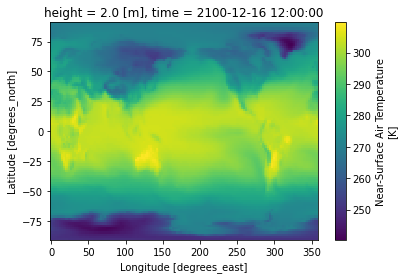

In [11]:
dsall[0].tas[-1,:,:].plot()

Maybe plot the zonal mean temperature...

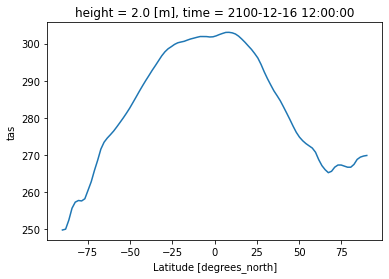

In [12]:
dsall[0].tas[-1,:,:].mean(dim='lon').plot()

Now let's calculate the global mean, and combine the two simulations into a single dataframe

In [13]:
  for i,ds in enumerate(dsall,start=0):
    #get the latitude
    lat=ds.tas.lat
    #define a numpy weight vector as the cosine of latitude
    weights = np.cos(np.deg2rad(lat))
    #give it an attribute
    weights.name = "weights"
    #apply the weight and then average along latitude (weighted) and longitude (not weighted)
    tmp_gm=ds.weighted(weights).mean(dim='lat').mean(dim='lon') 
    #add an ensemble dimension and label it with the name of the model
    tmp_gm=tmp_gm.expand_dims({'ens': [ds.source_id]})
    #now concatenate along the ensemble dimension
    if i==0:
        dac=tmp_gm
    else:
        dac=xr.concat([dac,tmp_gm],'ens')



Let's plot the annual means for the two models...  interesting, there's an offset...

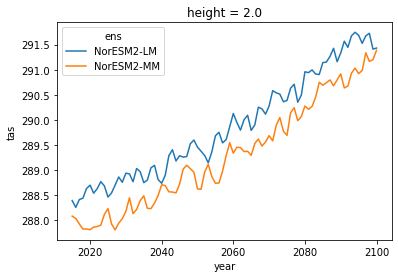

In [14]:
dac.tas.groupby('time.year').mean().plot.line(x='year')

Now let's save a new global mean netcdf to use later.

In [15]:
dac.to_netcdf('noresm_gm.nc')
